In [1]:
# Import packages
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

1. Import dataset

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/NLP/train.csv"

# Import data
df = pd.read_csv(path)
print(df.info())
df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


2. Filter needed values and plot to see the distribution of target variable 'sentiment'

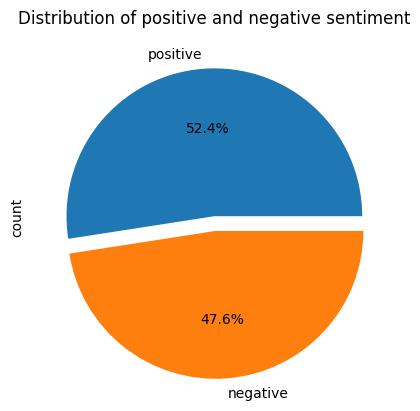

In [3]:
# Remove 'neutral' from column 'sentiment
df = df.loc[df["sentiment"] != 'neutral']


df['sentiment'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', title = "Distribution of positive and negative sentiment")
plt.show();

Crée une fonction que tu appelleras clean qui prend pour paramètre une phrase (donc un texte str) et qui retourne un texte (str) de tokens après application d'un stemmer ou d'un lemmatizer, séparés par des espaces.

In [4]:
# Drop unnecessary columns and reset index new df
df1 = df.drop(columns=["textID", "selected_text"])
df1.reset_index(drop=True, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       16363 non-null  object
 1   sentiment  16363 non-null  object
dtypes: object(2)
memory usage: 255.8+ KB


3. Create function to return a str applied methode Lemmatizer

In [ ]:
# Create function using lemmatizer

def clean(str):

  npl = spacy.load('en_core_web_sm')
  doc = npl(str)
  token = [token.lemma_ for token in doc]
  text_cleaned = ' '.join(token)
  return text_cleaned

clean("Hello, You are better when I am well.")

'hello , you be well when I be well .'

4. Add method to clean punctutation and stop words into the function clean

In [7]:
nlp = spacy.load('en_core_web_sm')
stopwordsenglish = list(stopwords.words('english'))

def clean_text(str):

  # Lemmatizer
  doc = nlp(str)
  token = [token.lemma_ for token in doc]
  text_lemma = ' '.join(token)

  # Remove punctutation and \n
  punc_pattern = r'[^\w\s]'
  text_remove_punc = re.sub(punc_pattern, '', text_lemma)

  # Remove stop words
  tokens = nltk.word_tokenize(text_remove_punc.lower())
  text_cleaned = [w for w in tokens if not w.lower() in stopwordsenglish]
  text_cleaned = ' '.join(text_cleaned)

  return text_cleaned


In [ ]:
### Test the function
print("Original text:", df1.loc[1]["text"])
print("Cleaned text:")
clean_text(df1.loc[1]["text"])

Original text: my boss is bullying me...
Cleaned text:


'boss bully'

In [ ]:
print("Original text:", df1.loc[0]["text"])
print("Cleaned text:")
clean_text(df1.loc[0]["text"])

Original text:  Sooo SAD I will miss you here in San Diego!!!
Cleaned text:


'sooo sad miss san diego'

In [ ]:
print("Original text:", df1.loc[3]["text"])
print("Cleaned text:")
clean_text(df1.iloc[3]["text"])

Original text:  Sons of ****, why couldn`t they put them on the releases we already bought
Cleaned text:


'son could not put release already buy'

In [ ]:
print("Original text:", df1.loc[5]["text"])
print("Cleaned text:")
clean_text(df1.loc[5]["text"])

Original text:  Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
Cleaned text:


'journey wow u become cool hehe possible'

5. Apply to df1

In [8]:
# Apply to df and took me 15m not 2-3m. OMG!!!!!
df1["cleaned"] = df1["text"].apply(clean_text)


In [ ]:
df1

,text,sentiment,cleaned
0,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
1,my boss is bullying me...,negative,boss bully
2,what interview! leave me alone,negative,interview leave alone
3,"Sons of ****, why couldn`t they put them on t...",negative,son couldnt put release already buy
4,2am feedings for the baby are fun when he is a...,positive,2 feeding baby fun smile coo
...,...,...,...
16358,enjoy ur night,positive,enjoy ur night
16359,wish we could come see u on Denver husband l...,negative,wish could come see u denver husband lose job ...
16360,I`ve wondered about rake to. The client has ...,negative,ive wonder rake client make clear net dont for...
16361,Yay good for both of you. Enjoy the break - y...,positive,yay good enjoy break probably need hectic week...


6. ML

In [9]:
#Initialize X, y
X = df1["cleaned"]
y = df1["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, train_size=0.75)

In [ ]:
### Bag of Words Transformation
vector = CountVectorizer().fit(X_train)

X_train_bow = vector.transform(X_train)
X_test_bow = vector.transform(X_test)



### TF-IDF Transformation
tfidf = TfidfVectorizer().fit(X_train)

X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

print("Shape of matrix Bag of Words:", X_test_bow, "\n\n")
print("Shape of matrix Tf-idf:", X_test_tf, "\n\n")

Shape of matrix Bag of Words:   (0, 6491)	1
  (0, 11138)	1
  (0, 11778)	1
  (1, 1511)	1
  (1, 3643)	1
  (1, 4980)	1
  (1, 5074)	1
  (1, 6491)	1
  (1, 9045)	1
  (1, 9538)	1
  (1, 10657)	1
  (1, 10853)	1
  (1, 11407)	1
  (1, 11679)	1
  (1, 13386)	1
  (2, 648)	1
  (2, 1584)	1
  (2, 2692)	1
  (2, 2741)	1
  (2, 11023)	1
  (2, 13030)	1
  (3, 2524)	1
  (3, 3209)	1
  (3, 4375)	1
  (3, 5074)	1
  :	:
  (4085, 787)	1
  (4085, 3150)	1
  (4085, 8823)	1
  (4085, 9058)	1
  (4085, 10901)	1
  (4085, 12034)	1
  (4085, 12725)	1
  (4086, 2192)	1
  (4086, 12034)	1
  (4087, 5770)	1
  (4087, 10486)	1
  (4087, 11522)	1
  (4088, 10853)	1
  (4088, 11076)	1
  (4088, 13275)	1
  (4089, 1269)	1
  (4089, 6377)	1
  (4090, 1462)	1
  (4090, 1478)	1
  (4090, 1780)	1
  (4090, 7389)	1
  (4090, 8515)	1
  (4090, 8731)	1
  (4090, 11472)	1
  (4090, 12208)	1 


Shape of matrix Tf-idf:   (0, 11778)	0.562860698402079
  (0, 11138)	0.7573981344789478
  (0, 6491)	0.3309620825444114
  (1, 13386)	0.24192923278267392
  (1, 11679)	0.27

In [ ]:
# Create a function of model Logistic Regression
def logistic_reg(X_train, y_train, X_test, y_test, method):
    model = LogisticRegression().fit(X_train, y_train)

    score = model.score(X_test, y_test)
    print('Test Score with', method, score, "\n\n")

    # Confusion matrix
    conf = pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = model.predict(X_test)),
             index = model.classes_ + "ACTUAL",
             columns = model.classes_ + " PREDICTED")
    print('Confusion Matrix with', method, "\n", conf)
    return model

In [ ]:
# BOW
logistic_reg(X_train_bow, y_train, X_test_bow, y_test, "Bag of Words")

Test Score with Bag of Words 0.8699584453678807 


Confusion Matrix with Bag of Words 
                 negative PREDICTED  positive PREDICTED
negativeACTUAL                1682                 253
positiveACTUAL                 279                1877


LogisticRegression()

In [ ]:
#TF-IDF
logistic_reg(X_train_tf, y_train, X_test_tf, y_test, "TF-IDF")

Test Score with TF-IDF 0.8714250794426791 


Confusion Matrix with TF-IDF 
                 negative PREDICTED  positive PREDICTED
negativeACTUAL                1689                 246
positiveACTUAL                 280                1876


LogisticRegression()

# Hyperparameters Tuning

So, I already got good score with the defaut hyparameters of LG model

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create a distionary of hyperparameters for GridSearch
dico = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'solver': ['lbfgs', 'liblinear']}



In [ ]:
# Initialze X, y of each method for GrideSearch model

#BOW Transformation
vector_grid = CountVectorizer().fit(X)
X_bow = vector_grid.transform(X)

# TF-IDF Transformation
tfidf_grid = TfidfVectorizer().fit(X)
X_tf = tfidf_grid.transform(X)


In [ ]:
# BOW
bow_gridsearch = GridSearchCV(LogisticRegression(), dico, cv=5).fit(X_bow, y)

print("Best score of BOW:", bow_gridsearch.best_score_, "\n")
print("Best param of BOW:", bow_gridsearch.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best score of BOW: 0.8716617475574401 

Best param of BOW: {'C': 1.0, 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
tfidf_gridsearch = GridSearchCV(LogisticRegression(), dico, cv=5).fit(X_tf, y)

print("Best score of TF-IDF:", bow_gridsearch.best_score_, "\n")
print("Best param of TF-IDF:", bow_gridsearch.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best score of TF-IDF: 0.8716617475574401 

Best param of TF-IDF: {'C': 1.0, 'solver': 'lbfgs'}


# Let's check the wrong predicted values with TF-IDF

In [10]:
tfidf = TfidfVectorizer().fit(X_train)

X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [13]:
# Create a df with columns actual and predicted value
model = LogisticRegression().fit(X_train_tf, y_train)

y_pred = pd.Series(model.predict(X_test_tf))

data = {"tweets_cleaned": X_test.reset_index(drop=True),
        "actual_sentiment": y_test.reset_index(drop=True),
        "predicted_sentiment": y_pred}

df_test = pd.concat(data,
               axis = 1)
df_test

,tweets_cleaned,actual_sentiment,predicted_sentiment
0,buttfuck stupid im silly forgetful,negative,negative
1,get well omg still believe didntgot picture so...,negative,negative
2,hollowbabeshere come utter shite bgt completel...,negative,negative
3,thank clayton go favorite greek resturant chur...,positive,positive
4,im watch moment sighs straighten hair take hou...,negative,negative
...,...,...,...
4086,cant take,negative,negative
4087,r u spin hookah rip,negative,negative
4088,want see show,negative,positive
4089,har vondt ryggen back hurt,negative,negative


In [16]:
wrong_prediction = df_test.loc[df_test["actual_sentiment"] != df_test["predicted_sentiment"]].sample(20)
wrong_prediction

,tweets_cleaned,actual_sentiment,predicted_sentiment
3864,laptop poope new harddrive need use dhs old pc...,negative,positive
131,oh god end first course dont believe yeh many ...,positive,negative
2626,get early feel good day walk work im feel alri...,positive,negative
392,blah work job one day job two night,negative,positive
3021,lilash im guessing right oh camera use insane ...,positive,negative
2863,milkshake hot day unsettle stomach,positive,negative
2994,yay get errand oh assortment control thing top...,negative,positive
940,nooo busy ever srsly pal im yet familiar iphon...,positive,negative
1762,nothing yet still look let sure lunch next week,positive,negative
1234,call high five dont miss hotshot xd,positive,negative


In [18]:
wrong_prediction.loc[3864]["tweets_cleaned"]

'laptop poope new harddrive need use dhs old pc maybe offline bsod happen many time safe mode'